# Module 3 - Supervised Learning

## Imports

In [9]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.model_selection import GridSearchCV, train_test_split

## Helper Functions

In [12]:
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, matthews_corrcoef

def performance_metrics(y, y_prediction):
    confusion = confusion_matrix(y, y_prediction)
    cmap = sb.light_palette("green", as_cmap=True)
    confusion_plot = pd.DataFrame(confusion)
    confusion_plot = confusion_plot.style.background_gradient(cmap=cmap)
    
    display(confusion_plot)
    print('%38s: %.4f' % ('Accuracy Score', accuracy_score(y, y_prediction, normalize=True))) #best performance is 1 with normalize == True
    print('%38s: %.4f' % ('F1-Score', f1_score(y, y_prediction, average='macro'))) # F1 = 2 * (precision * recall) / (precision + recall)
    print('%38s: %.4f' % ('Matthews Correlation Coefficient (MCC)', matthews_corrcoef(y, y_prediction))) #+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction
    print('%38s: %.4f' % ('Area Under the Curve (AUC)', matthews_corrcoef(y, y_prediction)))

In [58]:
from sklearn.model_selection import KFold

def cross_validation_KFold(clf, X_train, y_train, title, number_splits=10, plot=True):
    kf = KFold(n_splits=number_splits, shuffle=True)
    
    accuracy = []
    for train_index, test_index in kf.split(X_train):
        clf = clf.fit(X_train[train_index, :], y_train[train_index])
        y_train_prediction = clf.predict(X_train[train_index, :])
        
        accuracy.append(accuracy_score(y_train[train_index], y_train_prediction, normalize=True))
        print('%s: %.4f' % ('Accuracy Score', accuracy[-1]))
        
    if plot:
        ax = sb.scatterplot(x=range(1, len(accuracy) + 1), y=accuracy, palette="Blues_d")
        ax.set(xlabel='Iteration', ylabel='Accuracy', title='K-Fold ' + title)
        ax.figure.savefig('Module3/KFold_' + title + '.png')

In [96]:
def plot_GridSearchCV_results(cv_results, param_x, param_z, title, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sb.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title('GridSearchCV ' + title)
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig

## Load Data

In [40]:
# X, X_scaled, X_pca

X = np.load('Module3/data/X_pca.npy')
y = np.load('Module3/data/y.npy')

print(X.shape)
print(y.shape)

(26700, 43)
(26700,)


In [11]:
#DO NOT CHANGE

#split into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, train_size=0.70, random_state=0, shuffle=True)

print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X test:', X_test.shape)
print('y test:', y_test.shape)

X train: (18690, 43)
y train: (18690,)
X test: (8010, 43)
y test: (8010,)


## KNN

In [56]:
from sklearn.neighbors import KNeighborsClassifier

### Cross-Validation

Accuracy Score: 0.9985
Accuracy Score: 0.9992
Accuracy Score: 0.9993
Accuracy Score: 0.9988
Accuracy Score: 0.9987
Accuracy Score: 0.9989
Accuracy Score: 0.9988
Accuracy Score: 0.9992
Accuracy Score: 0.9992
Accuracy Score: 0.9989


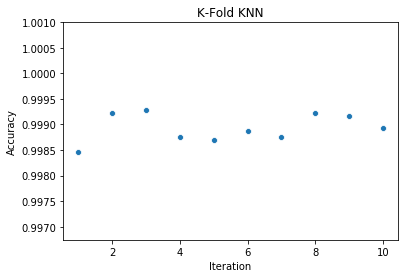

In [59]:
# Cross-Validation

cross_validation_KFold(KNeighborsClassifier(), X_train, y_train, 'KNN')

### Hyperparameter Tuning

In [108]:
n_neighbors = list(range(1, 11))
leaf_size = list(range(1, 5))
p = [2]
hyperparameters = dict(n_neighbors=n_neighbors, leaf_size=leaf_size, p=p)

clf = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=hyperparameters, cv=2, verbose=2, refit=True)
print(clf)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'leaf_size': [1, 2, 3, 4],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)


In [109]:
clf = clf.fit(X_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] leaf_size=1, n_neighbors=1, p=2 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. leaf_size=1, n_neighbors=1, p=2, total=   1.1s
[CV] leaf_size=1, n_neighbors=1, p=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .................. leaf_size=1, n_neighbors=1, p=2, total=   1.1s
[CV] leaf_size=1, n_neighbors=2, p=2 .................................
[CV] .................. leaf_size=1, n_neighbors=2, p=2, total=   2.3s
[CV] leaf_size=1, n_neighbors=2, p=2 .................................
[CV] .................. leaf_size=1, n_neighbors=2, p=2, total=   2.7s
[CV] leaf_size=1, n_neighbors=3, p=2 .................................
[CV] .................. leaf_size=1, n_neighbors=3, p=2, total=   4.1s
[CV] leaf_size=1, n_neighbors=3, p=2 .................................
[CV] .................. leaf_size=1, n_neighbors=3, p=2, total=   4.0s
[CV] leaf_size=1, n_neighbors=4, p=2 .................................
[CV] .................. leaf_size=1, n_neighbors=4, p=2, total=   5.3s
[CV] leaf_size=1, n_neighbors=4, p=2 .................................
[CV] .................. leaf_size=1, n_neighbors=4, p=2, total=   5.5s
[CV] leaf_size=1, n_neighbors=5, p=2 .................................
[CV] .

[CV] ................. leaf_size=3, n_neighbors=10, p=2, total=   5.7s
[CV] leaf_size=4, n_neighbors=1, p=2 .................................
[CV] .................. leaf_size=4, n_neighbors=1, p=2, total=   0.9s
[CV] leaf_size=4, n_neighbors=1, p=2 .................................
[CV] .................. leaf_size=4, n_neighbors=1, p=2, total=   0.8s
[CV] leaf_size=4, n_neighbors=2, p=2 .................................
[CV] .................. leaf_size=4, n_neighbors=2, p=2, total=   1.7s
[CV] leaf_size=4, n_neighbors=2, p=2 .................................
[CV] .................. leaf_size=4, n_neighbors=2, p=2, total=   1.7s
[CV] leaf_size=4, n_neighbors=3, p=2 .................................
[CV] .................. leaf_size=4, n_neighbors=3, p=2, total=   2.8s
[CV] leaf_size=4, n_neighbors=3, p=2 .................................
[CV] .................. leaf_size=4, n_neighbors=3, p=2, total=   2.9s
[CV] leaf_size=4, n_neighbors=4, p=2 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  6.7min finished


In [110]:
# print(pd.DataFrame(clf.cv_results_).head(5))
print(clf.best_score_)
print(clf.best_params_)

best_estimator = clf.best_estimator_
print(best_estimator)

0.9968967362225789
{'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


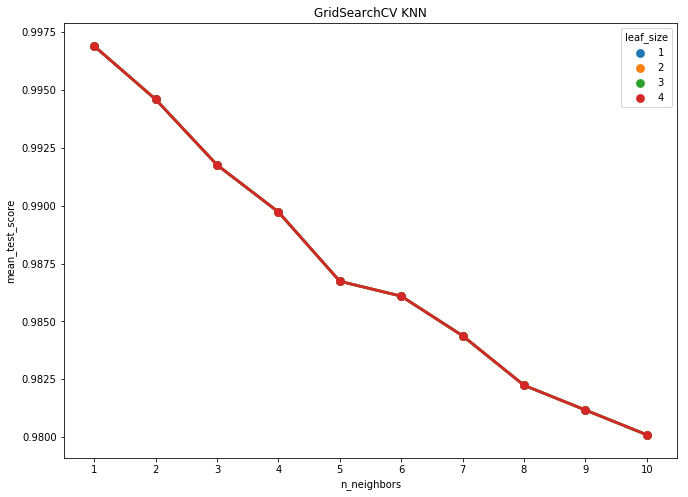

In [111]:
fig = plot_GridSearchCV_results(clf.cv_results_, 'n_neighbors', 'leaf_size', 'KNN')
fig.savefig('Module3/GridSearchCV_' + 'KNN.png')

### Results

In [112]:
clf = KNeighborsClassifier(n_neighbors=1, leaf_size=1)
clf = clf.fit(X_train, y_train)

In [113]:
y_train_prediction = clf.predict(X_train)
y_test_prediction = clf.predict(X_test)

In [114]:
print('---- Train ----')
performance_metrics(y_train, y_train_prediction)

---- Train ----


,0,1,2
0,6281,0,0
1,0,6141,0
2,0,0,6268


                        Accuracy Score: 1.0000
                              F1-Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
            Area Under the Curve (AUC): 1.0000


In [115]:
print('---- Test ----')
performance_metrics(y_test, y_test_prediction)

---- Test ----


,0,1,2
0,2658,1,0
1,0,2649,0
2,0,0,2702


                        Accuracy Score: 0.9999
                              F1-Score: 0.9999
Matthews Correlation Coefficient (MCC): 0.9998
            Area Under the Curve (AUC): 0.9998


In [116]:
# save model

dump(best_estimator, 'Module3/models/KNN.joblib')

['Module3/models/KNN.joblib']

## SVM

In [28]:
from sklearn.svm import SVC

### Cross-Validation

C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9636


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9656


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9635


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9637


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9652


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9646


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9643


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9647


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9649


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.9653


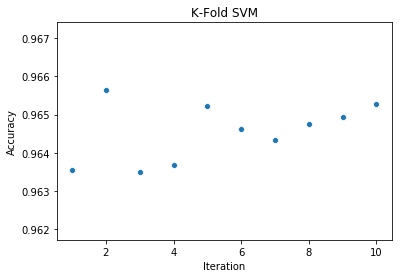

In [50]:
cross_validation_KFold(SVC(), X_train, y_train, 'SVM')

### Hyperparameter Tuning

In [91]:
C = list([1, 10, 100, 1000])
gamma = list([0.001, 0.01, 0.1, 1, 10])
hyperparameters = dict(C=C, gamma=gamma)

clf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=hyperparameters, cv=2, verbose=2, refit=True)
print(clf)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)


In [92]:
clf = clf.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] C=1, gamma=0.001 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. C=1, gamma=0.001, total=  12.5s
[CV] C=1, gamma=0.001 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV] ................................. C=1, gamma=0.001, total=  12.9s
[CV] C=1, gamma=0.01 .................................................
[CV] .................................. C=1, gamma=0.01, total=   6.6s
[CV] C=1, gamma=0.01 .................................................
[CV] .................................. C=1, gamma=0.01, total=   6.5s
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total=   3.0s
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total=   3.2s
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   4.4s
[CV] C=1, gamma=1 ....................................................
[CV] ..................................... C=1, gamma=1, total=   4.5s
[CV] C=1, gamma=10 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.6min finished


In [93]:
print(clf.best_score_)
print(clf.best_params_)

best_estimator = clf.best_estimator_
print(best_estimator)

0.9994114499732477
{'C': 10, 'gamma': 1}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


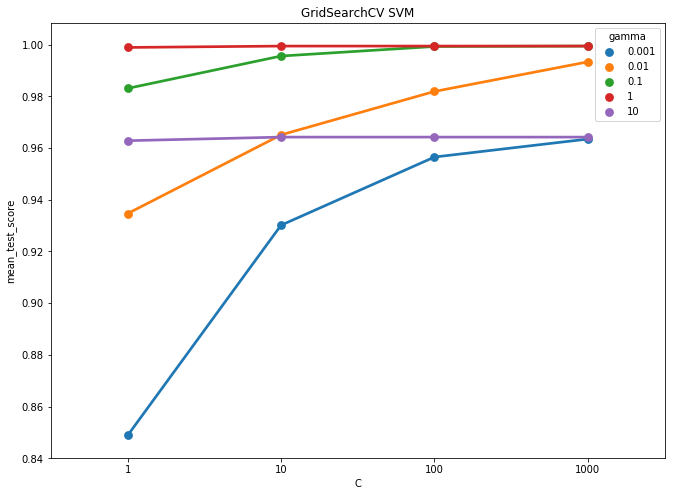

In [97]:
fig = plot_GridSearchCV_results(clf.cv_results_, 'C', 'gamma', 'SVM')
fig.savefig('Module3/GridSearchCV_' + 'SVM.png')

### Results

In [98]:
clf = SVC(kernel='rbf', C=10, gamma=1)
clf = clf.fit(X_train, y_train)

In [99]:
y_train_prediction = clf.predict(X_train)
y_test_prediction = clf.predict(X_test)

In [100]:
print('---- Train ----')
performance_metrics(y_train, y_train_prediction)

---- Train ----


,0,1,2
0,6281,0,0
1,0,6141,0
2,0,0,6268


                        Accuracy Score: 1.0000
                              F1-Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
            Area Under the Curve (AUC): 1.0000


In [101]:
print('---- Test ----')
performance_metrics(y_test, y_test_prediction)

---- Test ----


,0,1,2
0,2659,0,0
1,0,2649,0
2,0,0,2702


                        Accuracy Score: 1.0000
                              F1-Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
            Area Under the Curve (AUC): 1.0000


In [107]:
# save model

dump(clf, 'Module3/models/SVM.joblib')

['Module3/models/SVM.joblib']

## Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

### Cross-Validation

C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy Score: 0.9999
Accuracy Score: 1.0000
Accuracy Score: 0.9999
Accuracy Score: 1.0000
Accuracy Score: 0.9999
Accuracy Score: 1.0000
Accuracy Score: 1.0000
Accuracy Score: 0.9999
Accuracy Score: 0.9999
Accuracy Score: 0.9999


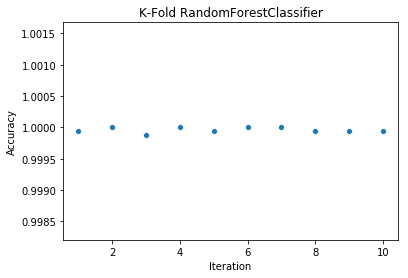

In [61]:
cross_validation_KFold(RandomForestClassifier(), X_train, y_train, 'RandomForestClassifier')

### Hyperparameter Tuning

In [78]:
max_depth = list(range(1, 20))
min_samples_leaf = list(range(1, 20))
hyperparameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=hyperparameters, cv=2, verbose=2, refit=True)
print(clf)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [79]:
clf.fit(X_train, y_train)

Fitting 2 folds for each of 361 candidates, totalling 722 fits
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] .................. max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] max_depth=1, min_samples_leaf=1 .................................
[CV] .................. max_depth=1, min_samples_leaf=1, total=   0.1s
[CV] max_depth=1, min_samples_leaf=2 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=2, total=   0.1s
[CV] max_depth=1, min_samples_leaf=2 .................................
[CV] .................. max_depth=1, min_samples_leaf=2, total=   0.1s
[CV] max_depth=1, min_samples_leaf=3 .................................
[CV] .................. max_depth=1, min_samples_leaf=3, total=   0.1s
[CV] max_depth=1, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=3, total=   0.1s
[CV] max_depth=1, min_samples_leaf=4 .................................
[CV] .................. max_depth=1, min_samples_leaf=4, total=   0.1s
[CV] max_depth=1, min_samples_leaf=4 .................................
[CV] .................. max_depth=1, min_samples_leaf=4, total=   0.1s
[CV] max_depth=1, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] max_depth=1, min_samples_leaf=5 .................................
[CV] .................. max_depth=1, min_samples_leaf=5, total=   0.1s
[CV] max_depth=1, min_samples_leaf=6 .................................
[CV] .................. max_depth=1, min_samples_leaf=6, total=   0.1s
[CV] max_depth=1, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=6, total=   0.1s
[CV] max_depth=1, min_samples_leaf=7 .................................
[CV] .................. max_depth=1, min_samples_leaf=7, total=   0.1s
[CV] max_depth=1, min_samples_leaf=7 .................................
[CV] .................. max_depth=1, min_samples_leaf=7, total=   0.1s
[CV] max_depth=1, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

[CV] .................. max_depth=1, min_samples_leaf=8, total=   0.1s
[CV] max_depth=1, min_samples_leaf=8 .................................
[CV] .................. max_depth=1, min_samples_leaf=8, total=   0.1s
[CV] max_depth=1, min_samples_leaf=9 .................................
[CV] .................. max_depth=1, min_samples_leaf=9, total=   0.1s
[CV] max_depth=1, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=1, min_samples_leaf=9, total=   0.1s
[CV] max_depth=1, min_samples_leaf=10 ................................
[CV] ................. max_depth=1, min_samples_leaf=10, total=   0.1s
[CV] max_depth=1, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=10, total=   0.1s
[CV] max_depth=1, min_samples_leaf=11 ................................
[CV] ................. max_depth=1, min_samples_leaf=11, total=   0.1s
[CV] max_depth=1, min_samples_leaf=11 ................................
[CV] ................. max_depth=1, min_samples_leaf=11, total=   0.1s
[CV] max_depth=1, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=12, total=   0.1s
[CV] max_depth=1, min_samples_leaf=12 ................................
[CV] ................. max_depth=1, min_samples_leaf=12, total=   0.1s
[CV] max_depth=1, min_samples_leaf=13 ................................
[CV] ................. max_depth=1, min_samples_leaf=13, total=   0.1s
[CV] max_depth=1, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

[CV] ................. max_depth=1, min_samples_leaf=13, total=   0.1s
[CV] max_depth=1, min_samples_leaf=14 ................................
[CV] ................. max_depth=1, min_samples_leaf=14, total=   0.1s
[CV] max_depth=1, min_samples_leaf=14 ................................
[CV] ................. max_depth=1, min_samples_leaf=14, total=   0.1s
[CV] max_depth=1, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=15, total=   0.1s
[CV] max_depth=1, min_samples_leaf=15 ................................
[CV] ................. max_depth=1, min_samples_leaf=15, total=   0.1s
[CV] max_depth=1, min_samples_leaf=16 ................................
[CV] ................. max_depth=1, min_samples_leaf=16, total=   0.1s
[CV] max_depth=1, min_samples_leaf=16 ................................
[CV] ................. max_depth=1, min_samples_leaf=16, total=   0.1s
[CV] max_depth=1, min_samples_leaf=17 ................................
[CV] ................. max_depth=1, min_samples_leaf=17, total=   0.1s
[CV] max_depth=1, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

[CV] ................. max_depth=1, min_samples_leaf=17, total=   0.1s
[CV] max_depth=1, min_samples_leaf=18 ................................
[CV] ................. max_depth=1, min_samples_leaf=18, total=   0.1s
[CV] max_depth=1, min_samples_leaf=18 ................................
[CV] ................. max_depth=1, min_samples_leaf=18, total=   0.1s
[CV] max_depth=1, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=1, min_samples_leaf=19, total=   0.1s
[CV] max_depth=1, min_samples_leaf=19 ................................
[CV] ................. max_depth=1, min_samples_leaf=19, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] max_depth=2, min_samples_leaf=1 .................................
[CV] .................. max_depth=2, min_samples_leaf=1, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=2, total=   0.1s
[CV] max_depth=2, min_samples_leaf=2 .................................
[CV] .................. max_depth=2, min_samples_leaf=2, total=   0.1s
[CV] max_depth=2, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=3, total=   0.2s
[CV] max_depth=2, min_samples_leaf=3 .................................
[CV] .................. max_depth=2, min_samples_leaf=3, total=   0.2s
[CV] max_depth=2, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=4, total=   0.1s
[CV] max_depth=2, min_samples_leaf=4 .................................
[CV] .................. max_depth=2, min_samples_leaf=4, total=   0.1s
[CV] max_depth=2, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=5 .................................
[CV] .................. max_depth=2, min_samples_leaf=5, total=   0.1s
[CV] max_depth=2, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=6, total=   0.2s
[CV] max_depth=2, min_samples_leaf=6 .................................
[CV] .................. max_depth=2, min_samples_leaf=6, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=7, total=   0.1s
[CV] max_depth=2, min_samples_leaf=7 .................................
[CV] .................. max_depth=2, min_samples_leaf=7, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=8, total=   0.1s
[CV] max_depth=2, min_samples_leaf=8 .................................
[CV] .................. max_depth=2, min_samples_leaf=8, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=2, min_samples_leaf=9, total=   0.1s
[CV] max_depth=2, min_samples_leaf=9 .................................
[CV] .................. max_depth=2, min_samples_leaf=9, total=   0.1s
[CV] max_depth=2, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=10 ................................
[CV] ................. max_depth=2, min_samples_leaf=10, total=   0.1s
[CV] max_depth=2, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=11, total=   0.1s
[CV] max_depth=2, min_samples_leaf=11 ................................
[CV] ................. max_depth=2, min_samples_leaf=11, total=   0.1s
[CV] max_depth=2, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=12, total=   0.1s
[CV] max_depth=2, min_samples_leaf=12 ................................
[CV] ................. max_depth=2, min_samples_leaf=12, total=   0.1s
[CV] max_depth=2, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=13, total=   0.2s
[CV] max_depth=2, min_samples_leaf=13 ................................
[CV] ................. max_depth=2, min_samples_leaf=13, total=   0.1s
[CV] max_depth=2, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=14, total=   0.1s
[CV] max_depth=2, min_samples_leaf=14 ................................
[CV] ................. max_depth=2, min_samples_leaf=14, total=   0.1s
[CV] max_depth=2, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=15, total=   0.1s
[CV] max_depth=2, min_samples_leaf=15 ................................
[CV] ................. max_depth=2, min_samples_leaf=15, total=   0.1s
[CV] max_depth=2, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=16, total=   0.1s
[CV] max_depth=2, min_samples_leaf=16 ................................
[CV] ................. max_depth=2, min_samples_leaf=16, total=   0.1s
[CV] max_depth=2, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=17, total=   0.1s
[CV] max_depth=2, min_samples_leaf=17 ................................
[CV] ................. max_depth=2, min_samples_leaf=17, total=   0.1s
[CV] max_depth=2, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=18, total=   0.1s
[CV] max_depth=2, min_samples_leaf=18 ................................
[CV] ................. max_depth=2, min_samples_leaf=18, total=   0.1s
[CV] max_depth=2, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=2, min_samples_leaf=19, total=   0.2s
[CV] max_depth=2, min_samples_leaf=19 ................................
[CV] ................. max_depth=2, min_samples_leaf=19, total=   0.1s
[CV] max_depth=3, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=1, total=   0.2s
[CV] max_depth=3, min_samples_leaf=1 .................................
[CV] .................. max_depth=3, min_samples_leaf=1, total=   0.2s
[CV] max_depth=3, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=2, total=   0.2s
[CV] max_depth=3, min_samples_leaf=2 .................................
[CV] .................. max_depth=3, min_samples_leaf=2, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=3, total=   0.2s
[CV] max_depth=3, min_samples_leaf=3 .................................
[CV] .................. max_depth=3, min_samples_leaf=3, total=   0.2s
[CV] max_depth=3, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=4, total=   0.2s
[CV] max_depth=3, min_samples_leaf=4 .................................
[CV] .................. max_depth=3, min_samples_leaf=4, total=   0.2s
[CV] max_depth=3, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=5 .................................
[CV] .................. max_depth=3, min_samples_leaf=5, total=   0.2s
[CV] max_depth=3, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=6, total=   0.2s
[CV] max_depth=3, min_samples_leaf=6 .................................
[CV] .................. max_depth=3, min_samples_leaf=6, total=   0.2s
[CV] max_depth=3, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=7, total=   0.2s
[CV] max_depth=3, min_samples_leaf=7 .................................
[CV] .................. max_depth=3, min_samples_leaf=7, total=   0.2s
[CV] max_depth=3, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=8, total=   0.2s
[CV] max_depth=3, min_samples_leaf=8 .................................
[CV] .................. max_depth=3, min_samples_leaf=8, total=   0.2s
[CV] max_depth=3, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=3, min_samples_leaf=9, total=   0.2s
[CV] max_depth=3, min_samples_leaf=9 .................................
[CV] .................. max_depth=3, min_samples_leaf=9, total=   0.2s
[CV] max_depth=3, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=10, total=   0.2s
[CV] max_depth=3, min_samples_leaf=10 ................................
[CV] ................. max_depth=3, min_samples_leaf=10, total=   0.1s
[CV] max_depth=3, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=11, total=   0.2s
[CV] max_depth=3, min_samples_leaf=11 ................................
[CV] ................. max_depth=3, min_samples_leaf=11, total=   0.2s
[CV] max_depth=3, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=12, total=   0.2s
[CV] max_depth=3, min_samples_leaf=12 ................................
[CV] ................. max_depth=3, min_samples_leaf=12, total=   0.1s
[CV] max_depth=3, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=13, total=   0.2s
[CV] max_depth=3, min_samples_leaf=13 ................................
[CV] ................. max_depth=3, min_samples_leaf=13, total=   0.1s
[CV] max_depth=3, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=14, total=   0.2s
[CV] max_depth=3, min_samples_leaf=14 ................................
[CV] ................. max_depth=3, min_samples_leaf=14, total=   0.2s
[CV] max_depth=3, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=15, total=   0.3s
[CV] max_depth=3, min_samples_leaf=15 ................................
[CV] ................. max_depth=3, min_samples_leaf=15, total=   0.2s
[CV] max_depth=3, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=16, total=   0.2s
[CV] max_depth=3, min_samples_leaf=16 ................................
[CV] ................. max_depth=3, min_samples_leaf=16, total=   0.1s
[CV] max_depth=3, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=17, total=   0.2s
[CV] max_depth=3, min_samples_leaf=17 ................................
[CV] ................. max_depth=3, min_samples_leaf=17, total=   0.1s
[CV] max_depth=3, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=18, total=   0.2s
[CV] max_depth=3, min_samples_leaf=18 ................................
[CV] ................. max_depth=3, min_samples_leaf=18, total=   0.1s
[CV] max_depth=3, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=3, min_samples_leaf=19, total=   0.2s
[CV] max_depth=3, min_samples_leaf=19 ................................
[CV] ................. max_depth=3, min_samples_leaf=19, total=   0.2s
[CV] max_depth=4, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=1, total=   0.2s
[CV] max_depth=4, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=1, total=   0.2s
[CV] max_depth=4, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=2, total=   0.2s
[CV] max_depth=4, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=2, total=   0.2s
[CV] max_depth=4, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=3, total=   0.2s
[CV] max_depth=4, min_samples_leaf=3 .................................
[CV] .................. max_depth=4, min_samples_leaf=3, total=   0.2s
[CV] max_depth=4, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=4, total=   0.2s
[CV] max_depth=4, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=4, total=   0.2s
[CV] max_depth=4, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=5, total=   0.2s
[CV] max_depth=4, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=6, total=   0.2s
[CV] max_depth=4, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=6, total=   0.2s
[CV] max_depth=4, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=7, total=   0.2s
[CV] max_depth=4, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=7, total=   0.2s
[CV] max_depth=4, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=8, total=   0.2s
[CV] max_depth=4, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=8, total=   0.2s
[CV] max_depth=4, min_samples_leaf=9 .................................
[CV] .................. max_depth=4, min_samples_leaf=9, total=   0.2s
[CV] max_depth=4, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=4, min_samples_leaf=9, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=11, total=   0.2s
[CV] max_depth=4, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=11, total=   0.2s
[CV] max_depth=4, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=12, total=   0.2s
[CV] max_depth=4, min_samples_leaf=12 ................................
[CV] ................. max_depth=4, min_samples_leaf=12, total=   0.2s
[CV] max_depth=4, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=13, total=   0.2s
[CV] max_depth=4, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=13, total=   0.2s
[CV] max_depth=4, min_samples_leaf=14 ................................
[CV] ................. max_depth=4, min_samples_leaf=14, total=   0.2s
[CV] max_depth=4, min_samples_leaf=14 ................................

C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



[CV] ................. max_depth=4, min_samples_leaf=14, total=   0.2s
[CV] max_depth=4, min_samples_leaf=15 ................................
[CV] ................. max_depth=4, min_samples_leaf=15, total=   0.2s
[CV] max_depth=4, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=15, total=   0.2s
[CV] max_depth=4, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=16, total=   0.2s
[CV] max_depth=4, min_samples_leaf=16 ................................
[CV] ................. max_depth=4, min_samples_leaf=16, total=   0.2s
[CV] max_depth=4, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=17, total=   0.2s
[CV] max_depth=4, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=17, total=   0.2s
[CV] max_depth=4, min_samples_leaf=18 ................................
[CV] ................. max_depth=4, min_samples_leaf=18, total=   0.2s
[CV] max_depth=4, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=18, total=   0.2s
[CV] max_depth=4, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=4, min_samples_leaf=19, total=   0.2s
[CV] max_depth=4, min_samples_leaf=19 ................................
[CV] ................. max_depth=4, min_samples_leaf=19, total=   0.2s
[CV] max_depth=5, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=1, total=   0.2s
[CV] max_depth=5, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=1, total=   0.2s
[CV] max_depth=5, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=2, total=   0.3s
[CV] max_depth=5, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=2, total=   0.2s
[CV] max_depth=5, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=3, total=   0.3s
[CV] max_depth=5, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=3, total=   0.3s
[CV] max_depth=5, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=4, total=   0.3s
[CV] max_depth=5, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=4, total=   0.2s
[CV] max_depth=5, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=5, total=   0.2s
[CV] max_depth=5, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=5, total=   0.3s
[CV] max_depth=5, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=6, total=   0.3s
[CV] max_depth=5, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=6, total=   0.2s
[CV] max_depth=5, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=7, total=   0.2s
[CV] max_depth=5, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=7, total=   0.2s
[CV] max_depth=5, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=8, total=   0.2s
[CV] max_depth=5, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=8, total=   0.3s
[CV] max_depth=5, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=9, total=   0.2s
[CV] max_depth=5, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=5, min_samples_leaf=9, total=   0.2s
[CV] max_depth=5, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=10, total=   0.3s
[CV] max_depth=5, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=10, total=   0.3s
[CV] max_depth=5, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=11, total=   0.3s
[CV] max_depth=5, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=11, total=   0.2s
[CV] max_depth=5, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=12, total=   0.2s
[CV] max_depth=5, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=12, total=   0.2s
[CV] max_depth=5, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=13, total=   0.3s
[CV] max_depth=5, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=13, total=   0.2s
[CV] max_depth=5, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=14, total=   0.2s
[CV] max_depth=5, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=14, total=   0.3s
[CV] max_depth=5, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=15, total=   0.3s
[CV] max_depth=5, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=15, total=   0.2s
[CV] max_depth=5, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=16, total=   0.2s
[CV] max_depth=5, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=16, total=   0.2s
[CV] max_depth=5, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=17, total=   0.3s
[CV] max_depth=5, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=17, total=   0.3s
[CV] max_depth=5, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=18, total=   0.2s
[CV] max_depth=5, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=18, total=   0.3s
[CV] max_depth=5, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=19, total=   0.3s
[CV] max_depth=5, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=5, min_samples_leaf=19, total=   0.3s
[CV] max_depth=6, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] max_depth=6, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=1, total=   0.3s
[CV] max_depth=6, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=2, total=   0.3s
[CV] max_depth=6, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=2, total=   0.4s
[CV] max_depth=6, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=3, total=   0.4s
[CV] max_depth=6, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=3, total=   0.3s
[CV] max_depth=6, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=4, total=   0.4s
[CV] max_depth=6, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=4, total=   0.4s
[CV] max_depth=6, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=5, total=   0.3s
[CV] max_depth=6, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=5, total=   0.3s
[CV] max_depth=6, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=6, total=   0.3s
[CV] max_depth=6, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=6, total=   0.3s
[CV] max_depth=6, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=7, total=   0.4s
[CV] max_depth=6, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=7, total=   0.3s
[CV] max_depth=6, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=8, total=   0.3s
[CV] max_depth=6, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=8, total=   0.3s
[CV] max_depth=6, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=9, total=   0.3s
[CV] max_depth=6, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=6, min_samples_leaf=9, total=   0.3s
[CV] max_depth=6, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=10, total=   0.3s
[CV] max_depth=6, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=10, total=   0.3s
[CV] max_depth=6, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=11, total=   0.3s
[CV] max_depth=6, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=11, total=   0.3s
[CV] max_depth=6, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=12, total=   0.3s
[CV] max_depth=6, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=12, total=   0.3s
[CV] max_depth=6, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=13, total=   0.3s
[CV] max_depth=6, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=13, total=   0.3s
[CV] max_depth=6, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=14, total=   0.3s
[CV] max_depth=6, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=14, total=   0.3s
[CV] max_depth=6, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=15, total=   0.3s
[CV] max_depth=6, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=15, total=   0.3s
[CV] max_depth=6, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=16, total=   0.3s
[CV] max_depth=6, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=16, total=   0.3s
[CV] max_depth=6, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=17, total=   0.3s
[CV] max_depth=6, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=17, total=   0.3s
[CV] max_depth=6, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=18, total=   0.3s
[CV] max_depth=6, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=18, total=   0.3s
[CV] max_depth=6, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=19, total=   0.3s
[CV] max_depth=6, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=6, min_samples_leaf=19, total=   0.3s
[CV] max_depth=7, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=1, total=   0.3s
[CV] max_depth=7, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=1, total=   0.3s
[CV] max_depth=7, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=2, total=   0.3s
[CV] max_depth=7, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=2, total=   0.4s
[CV] max_depth=7, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=3, total=   0.3s
[CV] max_depth=7, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=3, total=   0.3s
[CV] max_depth=7, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=4, total=   0.3s
[CV] max_depth=7, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=4, total=   0.3s
[CV] max_depth=7, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=5, total=   0.3s
[CV] max_depth=7, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=5, total=   0.3s
[CV] max_depth=7, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=6, total=   0.3s
[CV] max_depth=7, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=6, total=   0.3s
[CV] max_depth=7, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=7, total=   0.3s
[CV] max_depth=7, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=7, total=   0.5s
[CV] max_depth=7, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=8, total=   0.5s
[CV] max_depth=7, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=8, total=   0.3s
[CV] max_depth=7, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=9, total=   0.4s
[CV] max_depth=7, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=7, min_samples_leaf=9, total=   0.3s
[CV] max_depth=7, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=10, total=   0.3s
[CV] max_depth=7, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=10, total=   0.3s
[CV] max_depth=7, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=11, total=   0.3s
[CV] max_depth=7, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=11, total=   0.3s
[CV] max_depth=7, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=12, total=   0.3s
[CV] max_depth=7, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=12, total=   0.3s
[CV] max_depth=7, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=13, total=   0.3s
[CV] max_depth=7, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=13, total=   0.3s
[CV] max_depth=7, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=14, total=   0.3s
[CV] max_depth=7, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=14, total=   0.3s
[CV] max_depth=7, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=15, total=   0.3s
[CV] max_depth=7, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=15, total=   0.3s
[CV] max_depth=7, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=16, total=   0.3s
[CV] max_depth=7, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=16, total=   0.3s
[CV] max_depth=7, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=17, total=   0.3s
[CV] max_depth=7, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=17, total=   0.3s
[CV] max_depth=7, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=18, total=   0.3s
[CV] max_depth=7, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=18, total=   0.3s
[CV] max_depth=7, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=19, total=   0.3s
[CV] max_depth=7, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=7, min_samples_leaf=19, total=   0.3s
[CV] max_depth=8, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=1, total=   0.3s
[CV] max_depth=8, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=1, total=   0.3s
[CV] max_depth=8, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=2, total=   0.3s
[CV] max_depth=8, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=2, total=   0.4s
[CV] max_depth=8, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=3, total=   0.3s
[CV] max_depth=8, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=3, total=   0.3s
[CV] max_depth=8, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=4, total=   0.4s
[CV] max_depth=8, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=4, total=   0.3s
[CV] max_depth=8, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=5, total=   0.3s
[CV] max_depth=8, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=5, total=   0.3s
[CV] max_depth=8, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=6, total=   0.4s
[CV] max_depth=8, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=6, total=   0.4s
[CV] max_depth=8, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=7, total=   0.4s
[CV] max_depth=8, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=7, total=   0.3s
[CV] max_depth=8, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=8, total=   0.4s
[CV] max_depth=8, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=8, total=   0.4s
[CV] max_depth=8, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=9, total=   0.4s
[CV] max_depth=8, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=8, min_samples_leaf=9, total=   0.4s
[CV] max_depth=8, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=10, total=   0.4s
[CV] max_depth=8, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=10, total=   0.4s
[CV] max_depth=8, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=11, total=   0.4s
[CV] max_depth=8, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=11, total=   0.3s
[CV] max_depth=8, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=12, total=   0.4s
[CV] max_depth=8, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=12, total=   0.4s
[CV] max_depth=8, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=13, total=   0.4s
[CV] max_depth=8, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=13, total=   0.3s
[CV] max_depth=8, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=14, total=   0.4s
[CV] max_depth=8, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=14, total=   0.3s
[CV] max_depth=8, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=15, total=   0.3s
[CV] max_depth=8, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=15, total=   0.4s
[CV] max_depth=8, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=16, total=   0.4s
[CV] max_depth=8, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=16, total=   0.3s
[CV] max_depth=8, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=17, total=   0.3s
[CV] max_depth=8, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=17, total=   0.3s
[CV] max_depth=8, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=18, total=   0.3s
[CV] max_depth=8, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=18, total=   0.3s
[CV] max_depth=8, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=19, total=   0.4s
[CV] max_depth=8, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=8, min_samples_leaf=19, total=   0.3s
[CV] max_depth=9, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=1, total=   0.3s
[CV] max_depth=9, min_samples_leaf=1 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=1, total=   0.4s
[CV] max_depth=9, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=2, total=   0.4s
[CV] max_depth=9, min_samples_leaf=2 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=2, total=   0.3s
[CV] max_depth=9, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=3, total=   0.4s
[CV] max_depth=9, min_samples_leaf=3 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=3, total=   0.4s
[CV] max_depth=9, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=4, total=   0.4s
[CV] max_depth=9, min_samples_leaf=4 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=4, total=   0.4s
[CV] max_depth=9, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=5, total=   0.4s
[CV] max_depth=9, min_samples_leaf=5 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=5, total=   0.4s
[CV] max_depth=9, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=6, total=   0.4s
[CV] max_depth=9, min_samples_leaf=6 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=6, total=   0.4s
[CV] max_depth=9, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=7, total=   0.3s
[CV] max_depth=9, min_samples_leaf=7 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=7, total=   0.4s
[CV] max_depth=9, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=8, total=   0.4s
[CV] max_depth=9, min_samples_leaf=8 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=8, total=   0.4s
[CV] max_depth=9, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=9, total=   0.4s
[CV] max_depth=9, min_samples_leaf=9 .................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] .................. max_depth=9, min_samples_leaf=9, total=   0.4s
[CV] max_depth=9, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=10, total=   0.4s
[CV] max_depth=9, min_samples_leaf=10 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=10, total=   0.4s
[CV] max_depth=9, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=11, total=   0.4s
[CV] max_depth=9, min_samples_leaf=11 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=11, total=   0.4s
[CV] max_depth=9, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=12, total=   0.4s
[CV] max_depth=9, min_samples_leaf=12 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=12, total=   0.4s
[CV] max_depth=9, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=13, total=   0.4s
[CV] max_depth=9, min_samples_leaf=13 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=13, total=   0.4s
[CV] max_depth=9, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=14, total=   0.4s
[CV] max_depth=9, min_samples_leaf=14 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=14, total=   0.4s
[CV] max_depth=9, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=15, total=   0.3s
[CV] max_depth=9, min_samples_leaf=15 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=15, total=   0.3s
[CV] max_depth=9, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=16, total=   0.4s
[CV] max_depth=9, min_samples_leaf=16 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=16, total=   0.3s
[CV] max_depth=9, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=17, total=   0.3s
[CV] max_depth=9, min_samples_leaf=17 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=17, total=   0.3s
[CV] max_depth=9, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=18, total=   0.4s
[CV] max_depth=9, min_samples_leaf=18 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=18, total=   0.3s
[CV] max_depth=9, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=19, total=   0.3s
[CV] max_depth=9, min_samples_leaf=19 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=9, min_samples_leaf=19, total=   0.3s
[CV] max_depth=10, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=1, total=   0.4s
[CV] max_depth=10, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=2, total=   0.4s
[CV] max_depth=10, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=2, total=   0.4s
[CV] max_depth=10, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=3, total=   0.4s
[CV] max_depth=10, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=4, total=   0.4s
[CV] max_depth=10, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=4, total=   0.6s
[CV] max_depth=10, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=5, total=   0.4s
[CV] max_depth=10, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=5, total=   0.4s
[CV] max_depth=10, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=6, total=   0.4s
[CV] max_depth=10, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=6, total=   0.4s
[CV] max_depth=10, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=7, total=   0.4s
[CV] max_depth=10, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=7, total=   0.4s
[CV] max_depth=10, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=8, total=   0.4s
[CV] max_depth=10, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=8, total=   0.4s
[CV] max_depth=10, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=9, total=   0.4s
[CV] max_depth=10, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=10, min_samples_leaf=9, total=   0.4s
[CV] max_depth=10, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=10, total=   0.4s
[CV] max_depth=10, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=10, total=   0.4s
[CV] max_depth=10, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=11, total=   0.4s
[CV] max_depth=10, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=11, total=   0.5s
[CV] max_depth=10, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=12, total=   0.5s
[CV] max_depth=10, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=12, total=   0.4s
[CV] max_depth=10, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=13, total=   0.4s
[CV] max_depth=10, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=13, total=   0.4s
[CV] max_depth=10, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=14, total=   0.4s
[CV] max_depth=10, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=14, total=   0.4s
[CV] max_depth=10, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=15, total=   0.4s
[CV] max_depth=10, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=15, total=   0.4s
[CV] max_depth=10, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=16, total=   0.3s
[CV] max_depth=10, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=16, total=   0.4s
[CV] max_depth=10, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=17, total=   0.4s
[CV] max_depth=10, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=17, total=   0.4s
[CV] max_depth=10, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=18, total=   0.4s
[CV] max_depth=10, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=18, total=   0.4s
[CV] max_depth=10, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=19, total=   0.3s
[CV] max_depth=10, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=10, min_samples_leaf=19, total=   0.4s
[CV] max_depth=11, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=1, total=   0.4s
[CV] max_depth=11, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=1, total=   0.4s
[CV] max_depth=11, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=2, total=   0.4s
[CV] max_depth=11, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=2, total=   0.4s
[CV] max_depth=11, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=3, total=   0.4s
[CV] max_depth=11, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=3, total=   0.4s
[CV] max_depth=11, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=4, total=   0.4s
[CV] max_depth=11, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=4, total=   0.4s
[CV] max_depth=11, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=5, total=   0.4s
[CV] max_depth=11, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=5, total=   0.4s
[CV] max_depth=11, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=6, total=   0.4s
[CV] max_depth=11, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=6, total=   0.4s
[CV] max_depth=11, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=7, total=   0.4s
[CV] max_depth=11, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=7, total=   0.5s
[CV] max_depth=11, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=8, total=   0.4s
[CV] max_depth=11, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=8, total=   0.4s
[CV] max_depth=11, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=9, total=   0.4s
[CV] max_depth=11, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=11, min_samples_leaf=9, total=   0.4s
[CV] max_depth=11, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=10, total=   0.5s
[CV] max_depth=11, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=10, total=   0.4s
[CV] max_depth=11, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=11, total=   0.4s
[CV] max_depth=11, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=11, total=   0.4s
[CV] max_depth=11, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=12, total=   0.4s
[CV] max_depth=11, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=12, total=   0.4s
[CV] max_depth=11, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=13, total=   0.4s
[CV] max_depth=11, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=13, total=   0.4s
[CV] max_depth=11, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=14, total=   0.5s
[CV] max_depth=11, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=14, total=   0.4s
[CV] max_depth=11, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=15, total=   0.4s
[CV] max_depth=11, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=15, total=   0.4s
[CV] max_depth=11, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=16, total=   0.4s
[CV] max_depth=11, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=16, total=   0.4s
[CV] max_depth=11, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=17, total=   0.4s
[CV] max_depth=11, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=17, total=   0.4s
[CV] max_depth=11, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=18, total=   0.4s
[CV] max_depth=11, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=18, total=   0.3s
[CV] max_depth=11, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=19, total=   0.3s
[CV] max_depth=11, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=11, min_samples_leaf=19, total=   0.4s
[CV] max_depth=12, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=1, total=   0.4s
[CV] max_depth=12, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=1, total=   0.4s
[CV] max_depth=12, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=2, total=   0.4s
[CV] max_depth=12, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=2, total=   0.4s
[CV] max_depth=12, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=3, total=   0.5s
[CV] max_depth=12, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=3, total=   0.4s
[CV] max_depth=12, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=4, total=   0.4s
[CV] max_depth=12, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=4, total=   0.4s
[CV] max_depth=12, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=5, total=   0.4s
[CV] max_depth=12, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=5, total=   0.4s
[CV] max_depth=12, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=6, total=   0.4s
[CV] max_depth=12, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=6, total=   0.4s
[CV] max_depth=12, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=7, total=   0.4s
[CV] max_depth=12, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=7, total=   0.4s
[CV] max_depth=12, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=8, total=   0.4s
[CV] max_depth=12, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=8, total=   0.4s
[CV] max_depth=12, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=9, total=   0.4s
[CV] max_depth=12, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=12, min_samples_leaf=9, total=   0.5s
[CV] max_depth=12, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=10, total=   0.4s
[CV] max_depth=12, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=10, total=   0.4s
[CV] max_depth=12, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=11, total=   0.4s
[CV] max_depth=12, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=11, total=   0.4s
[CV] max_depth=12, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=12, total=   0.4s
[CV] max_depth=12, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=12, total=   0.4s
[CV] max_depth=12, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=13, total=   0.4s
[CV] max_depth=12, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=13, total=   0.4s
[CV] max_depth=12, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=14, total=   0.4s
[CV] max_depth=12, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=14, total=   0.5s
[CV] max_depth=12, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=15, total=   0.4s
[CV] max_depth=12, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=15, total=   0.4s
[CV] max_depth=12, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=16, total=   0.5s
[CV] max_depth=12, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=16, total=   0.4s
[CV] max_depth=12, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=17, total=   0.4s
[CV] max_depth=12, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=17, total=   0.4s
[CV] max_depth=12, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=18, total=   0.4s
[CV] max_depth=12, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=18, total=   0.4s
[CV] max_depth=12, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=19, total=   0.4s
[CV] max_depth=12, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=12, min_samples_leaf=19, total=   0.4s
[CV] max_depth=13, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=1, total=   0.5s
[CV] max_depth=13, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=1, total=   0.4s
[CV] max_depth=13, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=2, total=   0.6s
[CV] max_depth=13, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=2, total=   0.5s
[CV] max_depth=13, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=3, total=   0.5s
[CV] max_depth=13, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=3, total=   0.4s
[CV] max_depth=13, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=4, total=   0.4s
[CV] max_depth=13, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=4, total=   0.4s
[CV] max_depth=13, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=5, total=   0.4s
[CV] max_depth=13, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=5, total=   0.4s
[CV] max_depth=13, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=6, total=   0.4s
[CV] max_depth=13, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=6, total=   0.4s
[CV] max_depth=13, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=7, total=   0.4s
[CV] max_depth=13, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=7, total=   0.4s
[CV] max_depth=13, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=8, total=   0.4s
[CV] max_depth=13, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=8, total=   0.4s
[CV] max_depth=13, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=9, total=   0.4s
[CV] max_depth=13, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=13, min_samples_leaf=9, total=   0.4s
[CV] max_depth=13, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=10, total=   0.4s
[CV] max_depth=13, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=10, total=   0.4s
[CV] max_depth=13, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=11, total=   0.4s
[CV] max_depth=13, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=11, total=   0.4s
[CV] max_depth=13, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=12, total=   0.4s
[CV] max_depth=13, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=12, total=   0.4s
[CV] max_depth=13, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=13, total=   0.4s
[CV] max_depth=13, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=13, total=   0.4s
[CV] max_depth=13, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=14, total=   0.4s
[CV] max_depth=13, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=14, total=   0.4s
[CV] max_depth=13, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=15, total=   0.4s
[CV] max_depth=13, min_samples_leaf=15 ...............................
[CV] ................ max_depth=13, min_samples_leaf=15, total=   0.4s
[CV] max_depth=13, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=16, total=   0.4s
[CV] max_depth=13, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=16, total=   0.4s
[CV] max_depth=13, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=17, total=   0.4s
[CV] max_depth=13, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=17, total=   0.4s
[CV] max_depth=13, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=18, total=   0.4s
[CV] max_depth=13, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=18, total=   0.4s
[CV] max_depth=13, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=19, total=   0.4s
[CV] max_depth=13, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=13, min_samples_leaf=19, total=   0.4s
[CV] max_depth=14, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=1, total=   0.4s
[CV] max_depth=14, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=1, total=   0.4s
[CV] max_depth=14, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=2, total=   0.4s
[CV] max_depth=14, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=2, total=   0.4s
[CV] max_depth=14, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=3, total=   0.4s
[CV] max_depth=14, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=3, total=   0.4s
[CV] max_depth=14, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=4, total=   0.4s
[CV] max_depth=14, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=4, total=   0.4s
[CV] max_depth=14, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=5, total=   0.4s
[CV] max_depth=14, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=5, total=   0.4s
[CV] max_depth=14, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=6, total=   0.4s
[CV] max_depth=14, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=6, total=   0.4s
[CV] max_depth=14, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=7, total=   0.5s
[CV] max_depth=14, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=7, total=   0.5s
[CV] max_depth=14, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=8, total=   0.4s
[CV] max_depth=14, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=8, total=   0.5s
[CV] max_depth=14, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=9, total=   0.4s
[CV] max_depth=14, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=14, min_samples_leaf=9, total=   0.4s
[CV] max_depth=14, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=10, total=   0.4s
[CV] max_depth=14, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=10, total=   0.5s
[CV] max_depth=14, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=11, total=   0.4s
[CV] max_depth=14, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=11, total=   0.4s
[CV] max_depth=14, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=12, total=   0.4s
[CV] max_depth=14, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=12, total=   0.4s
[CV] max_depth=14, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=13, total=   0.4s
[CV] max_depth=14, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=13, total=   0.4s
[CV] max_depth=14, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=14, total=   0.4s
[CV] max_depth=14, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=14, total=   0.4s
[CV] max_depth=14, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=15, total=   0.4s
[CV] max_depth=14, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=15, total=   0.4s
[CV] max_depth=14, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=16, total=   0.5s
[CV] max_depth=14, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=16, total=   0.4s
[CV] max_depth=14, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=17, total=   0.4s
[CV] max_depth=14, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=17, total=   0.4s
[CV] max_depth=14, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=18, total=   0.4s
[CV] max_depth=14, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=18, total=   0.5s
[CV] max_depth=14, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=19, total=   0.4s
[CV] max_depth=14, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=14, min_samples_leaf=19, total=   0.4s
[CV] max_depth=15, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=1, total=   0.5s
[CV] max_depth=15, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=1, total=   0.5s
[CV] max_depth=15, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=2, total=   0.5s
[CV] max_depth=15, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=2, total=   0.5s
[CV] max_depth=15, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=3, total=   0.5s
[CV] max_depth=15, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=3, total=   0.6s
[CV] max_depth=15, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=4, total=   0.6s
[CV] max_depth=15, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=4, total=   0.4s
[CV] max_depth=15, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=5, total=   0.5s
[CV] max_depth=15, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=5, total=   0.4s
[CV] max_depth=15, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=6, total=   0.5s
[CV] max_depth=15, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=6, total=   0.4s
[CV] max_depth=15, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=7, total=   0.4s
[CV] max_depth=15, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=7, total=   0.4s
[CV] max_depth=15, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=8, total=   0.4s
[CV] max_depth=15, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=8, total=   0.4s
[CV] max_depth=15, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=9, total=   0.4s
[CV] max_depth=15, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=15, min_samples_leaf=9, total=   0.4s
[CV] max_depth=15, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=10, total=   0.4s
[CV] max_depth=15, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=10, total=   0.5s
[CV] max_depth=15, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=11, total=   0.5s
[CV] max_depth=15, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=11, total=   0.4s
[CV] max_depth=15, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=12, total=   0.4s
[CV] max_depth=15, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=12, total=   0.4s
[CV] max_depth=15, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=13, total=   0.4s
[CV] max_depth=15, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=13, total=   0.6s
[CV] max_depth=15, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=14, total=   0.4s
[CV] max_depth=15, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=14, total=   0.4s
[CV] max_depth=15, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=15, total=   0.4s
[CV] max_depth=15, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=15, total=   0.4s
[CV] max_depth=15, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=16, total=   0.4s
[CV] max_depth=15, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=16, total=   0.4s
[CV] max_depth=15, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=17, total=   0.5s
[CV] max_depth=15, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=17, total=   0.5s
[CV] max_depth=15, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=18, total=   0.6s
[CV] max_depth=15, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=18, total=   0.6s
[CV] max_depth=15, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=19, total=   0.4s
[CV] max_depth=15, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=15, min_samples_leaf=19, total=   0.4s
[CV] max_depth=16, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=1, total=   0.5s
[CV] max_depth=16, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=1, total=   0.5s
[CV] max_depth=16, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=2, total=   0.4s
[CV] max_depth=16, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=2, total=   0.4s
[CV] max_depth=16, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=3, total=   0.5s
[CV] max_depth=16, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=3, total=   0.5s
[CV] max_depth=16, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=4, total=   0.4s
[CV] max_depth=16, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=4, total=   0.4s
[CV] max_depth=16, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=5, total=   0.4s
[CV] max_depth=16, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=5, total=   0.4s
[CV] max_depth=16, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=6, total=   0.4s
[CV] max_depth=16, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=6, total=   0.4s
[CV] max_depth=16, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=7, total=   0.4s
[CV] max_depth=16, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=7, total=   0.4s
[CV] max_depth=16, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=8, total=   0.4s
[CV] max_depth=16, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=8, total=   0.4s
[CV] max_depth=16, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=9, total=   0.4s
[CV] max_depth=16, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=16, min_samples_leaf=9, total=   0.5s
[CV] max_depth=16, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=10, total=   0.4s
[CV] max_depth=16, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=10, total=   0.4s
[CV] max_depth=16, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=11, total=   0.6s
[CV] max_depth=16, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=11, total=   0.6s
[CV] max_depth=16, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=12, total=   0.4s
[CV] max_depth=16, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=12, total=   0.4s
[CV] max_depth=16, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=13, total=   0.4s
[CV] max_depth=16, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=13, total=   0.4s
[CV] max_depth=16, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=14, total=   0.4s
[CV] max_depth=16, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=14, total=   0.6s
[CV] max_depth=16, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=15, total=   0.5s
[CV] max_depth=16, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=15, total=   0.5s
[CV] max_depth=16, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=16, total=   0.4s
[CV] max_depth=16, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=16, total=   0.5s
[CV] max_depth=16, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=17, total=   0.6s
[CV] max_depth=16, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=17, total=   0.6s
[CV] max_depth=16, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=18, total=   0.4s
[CV] max_depth=16, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=18, total=   0.4s
[CV] max_depth=16, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=19, total=   0.4s
[CV] max_depth=16, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=16, min_samples_leaf=19, total=   0.4s
[CV] max_depth=17, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=1, total=   0.5s
[CV] max_depth=17, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=1, total=   0.5s
[CV] max_depth=17, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=2, total=   0.5s
[CV] max_depth=17, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=2, total=   0.5s
[CV] max_depth=17, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=3, total=   0.5s
[CV] max_depth=17, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=3, total=   0.4s
[CV] max_depth=17, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=4, total=   0.4s
[CV] max_depth=17, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=4, total=   0.4s
[CV] max_depth=17, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=5, total=   0.4s
[CV] max_depth=17, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=5, total=   0.4s
[CV] max_depth=17, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=6, total=   0.5s
[CV] max_depth=17, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=6, total=   0.5s
[CV] max_depth=17, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=7, total=   0.4s
[CV] max_depth=17, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=7, total=   0.4s
[CV] max_depth=17, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=8, total=   0.4s
[CV] max_depth=17, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=8, total=   0.4s
[CV] max_depth=17, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=9, total=   0.4s
[CV] max_depth=17, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=17, min_samples_leaf=9, total=   0.4s
[CV] max_depth=17, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=10, total=   0.4s
[CV] max_depth=17, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=10, total=   0.4s
[CV] max_depth=17, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=11, total=   0.4s
[CV] max_depth=17, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=11, total=   0.4s
[CV] max_depth=17, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=12, total=   0.4s
[CV] max_depth=17, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=12, total=   0.4s
[CV] max_depth=17, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=13, total=   0.4s
[CV] max_depth=17, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=13, total=   0.4s
[CV] max_depth=17, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=14, total=   0.4s
[CV] max_depth=17, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=14, total=   0.4s
[CV] max_depth=17, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=15, total=   0.4s
[CV] max_depth=17, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=15, total=   0.4s
[CV] max_depth=17, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=16, total=   0.4s
[CV] max_depth=17, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=16, total=   0.4s
[CV] max_depth=17, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=17, total=   0.4s
[CV] max_depth=17, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=17, total=   0.4s
[CV] max_depth=17, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=18, total=   0.4s
[CV] max_depth=17, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=18, total=   0.4s
[CV] max_depth=17, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=19, total=   0.4s
[CV] max_depth=17, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=17, min_samples_leaf=19, total=   0.4s
[CV] max_depth=18, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=1, total=   0.5s
[CV] max_depth=18, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=1, total=   0.5s
[CV] max_depth=18, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=2, total=   0.5s
[CV] max_depth=18, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=2, total=   0.5s
[CV] max_depth=18, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=3, total=   0.5s
[CV] max_depth=18, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=3, total=   0.4s
[CV] max_depth=18, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=4, total=   0.4s
[CV] max_depth=18, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=4, total=   0.5s
[CV] max_depth=18, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=5, total=   0.4s
[CV] max_depth=18, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=5, total=   0.4s
[CV] max_depth=18, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=6, total=   0.4s
[CV] max_depth=18, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=6, total=   0.5s
[CV] max_depth=18, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=7, total=   0.4s
[CV] max_depth=18, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=7, total=   0.5s
[CV] max_depth=18, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=8, total=   0.4s
[CV] max_depth=18, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=8, total=   0.4s
[CV] max_depth=18, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=9, total=   0.4s
[CV] max_depth=18, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=18, min_samples_leaf=9, total=   0.4s
[CV] max_depth=18, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=10, total=   0.4s
[CV] max_depth=18, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=10, total=   0.4s
[CV] max_depth=18, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=11, total=   0.4s
[CV] max_depth=18, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=11, total=   0.4s
[CV] max_depth=18, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=12, total=   0.4s
[CV] max_depth=18, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=12, total=   0.4s
[CV] max_depth=18, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=13, total=   0.4s
[CV] max_depth=18, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=13, total=   0.4s
[CV] max_depth=18, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=14, total=   0.4s
[CV] max_depth=18, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=14, total=   0.4s
[CV] max_depth=18, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=15, total=   0.4s
[CV] max_depth=18, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=15, total=   0.4s
[CV] max_depth=18, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=16, total=   0.4s
[CV] max_depth=18, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=16, total=   0.4s
[CV] max_depth=18, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=17, total=   0.4s
[CV] max_depth=18, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=17, total=   0.4s
[CV] max_depth=18, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=18, total=   0.4s
[CV] max_depth=18, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=18, total=   0.4s
[CV] max_depth=18, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=19, total=   0.4s
[CV] max_depth=18, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=18, min_samples_leaf=19, total=   0.4s
[CV] max_depth=19, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=1, total=   0.5s
[CV] max_depth=19, min_samples_leaf=1 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=1, total=   0.5s
[CV] max_depth=19, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=2, total=   0.4s
[CV] max_depth=19, min_samples_leaf=2 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=2, total=   0.5s
[CV] max_depth=19, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=3, total=   0.5s
[CV] max_depth=19, min_samples_leaf=3 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=3, total=   0.5s
[CV] max_depth=19, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=4, total=   0.5s
[CV] max_depth=19, min_samples_leaf=4 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=4, total=   0.5s
[CV] max_depth=19, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=5, total=   0.4s
[CV] max_depth=19, min_samples_leaf=5 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=5, total=   0.5s
[CV] max_depth=19, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=6, total=   0.5s
[CV] max_depth=19, min_samples_leaf=6 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=6, total=   0.4s
[CV] max_depth=19, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=7, total=   0.5s
[CV] max_depth=19, min_samples_leaf=7 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=7, total=   0.4s
[CV] max_depth=19, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=8, total=   0.4s
[CV] max_depth=19, min_samples_leaf=8 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=8, total=   0.5s
[CV] max_depth=19, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=9, total=   0.4s
[CV] max_depth=19, min_samples_leaf=9 ................................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................. max_depth=19, min_samples_leaf=9, total=   0.4s
[CV] max_depth=19, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=10, total=   0.4s
[CV] max_depth=19, min_samples_leaf=10 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=10, total=   0.4s
[CV] max_depth=19, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=11, total=   0.4s
[CV] max_depth=19, min_samples_leaf=11 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=11, total=   0.5s
[CV] max_depth=19, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=12, total=   0.5s
[CV] max_depth=19, min_samples_leaf=12 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=12, total=   0.4s
[CV] max_depth=19, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=13, total=   0.5s
[CV] max_depth=19, min_samples_leaf=13 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=13, total=   0.5s
[CV] max_depth=19, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=14, total=   0.4s
[CV] max_depth=19, min_samples_leaf=14 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=14, total=   0.4s
[CV] max_depth=19, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=15, total=   0.4s
[CV] max_depth=19, min_samples_leaf=15 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=15, total=   0.4s
[CV] max_depth=19, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=16, total=   0.4s
[CV] max_depth=19, min_samples_leaf=16 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=16, total=   0.4s
[CV] max_depth=19, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=17, total=   0.4s
[CV] max_depth=19, min_samples_leaf=17 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=17, total=   0.4s
[CV] max_depth=19, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=18, total=   0.4s
[CV] max_depth=19, min_samples_leaf=18 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=18, total=   0.4s
[CV] max_depth=19, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=19, total=   0.4s
[CV] max_depth=19, min_samples_leaf=19 ...............................


C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV] ................ max_depth=19, min_samples_leaf=19, total=   0.5s


[Parallel(n_jobs=1)]: Done 722 out of 722 | elapsed:  4.1min finished
C:\Users\alexa\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [82]:
print(clf.best_score_)
print(clf.best_params_)

best_estimator = clf.best_estimator_
print(best_estimator)

0.9890315676832531
{'max_depth': 18, 'min_samples_leaf': 1}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=18, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


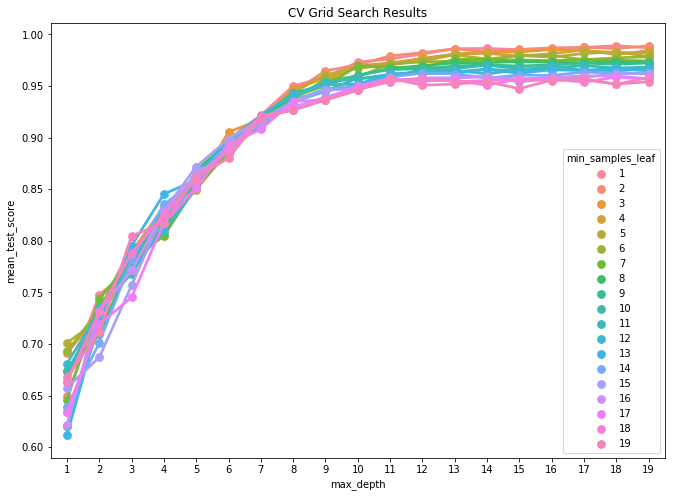

In [81]:
fig = plot_GridSearchCV_results(clf.cv_results_, 'max_depth', 'min_samples_leaf')
fig.savefig('Module3/GridSearchCV_' + 'RandomForestClassifier.png')

### Results

In [86]:
clf = RandomForestClassifier(n_estimators=100, max_depth=18, min_samples_leaf=1)
clf = clf.fit(X_train, y_train)

In [87]:
y_train_prediction = clf.predict(X_train)
y_test_prediction = clf.predict(X_test)

In [88]:
print('---- Train ----')
performance_metrics(y_train, y_train_prediction)

---- Train ----


,0,1,2
0,6281,0,0
1,0,6141,0
2,0,0,6268


                        Accuracy Score: 1.0000
                              F1-Score: 1.0000
Matthews Correlation Coefficient (MCC): 1.0000
            Area Under the Curve (AUC): 1.0000


In [89]:
print('---- Test ----')
performance_metrics(y_test, y_test_prediction)

---- Test ----


,0,1,2
0,2659,0,0
1,0,2648,1
2,0,0,2702


                        Accuracy Score: 0.9999
                              F1-Score: 0.9999
Matthews Correlation Coefficient (MCC): 0.9998
            Area Under the Curve (AUC): 0.9998


In [90]:
# save model

dump(clf, 'Module3/models/RandomForestClassifier.joblib')

['Module3/models/RandomForestClassifier.joblib']